In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from lda_model import *
from sklearn.metrics import f1_score,accuracy_score,precision_recall_fscore_support,balanced_accuracy_score

In [3]:
key=pd.read_csv("SocialMedia/Keyword.csv",delimiter=';')
key.drop_duplicates(subset='Keyword',inplace=True)
keys=[i.strip() for i in key.Keyword.values]

In [4]:
import fasttext
from gensim.models import FastText

In [5]:
data=pd.read_csv("get_data/data_tweeter/merge/data.csv")[['full_text']]
colum_text='full_text'

new_values=[]

functions=[remove_RT,remove_url,replace_tags,remove_arroba,remove_emoji,remove_stopwords]
for i in data[colum_text].values:
    text=i
    for j in functions:
        text=j(text)
    new_values.append(text)
    
new_values_join=[]
for i in new_values:
    new_values_join.append(" ".join(i))
data["CleanText"]=new_values_join
colum_text='CleanText'
data=data.drop_duplicates(subset='CleanText').reset_index(drop=True)

In [6]:
tweets_keys=new_values+keys

In [7]:
model = FastText(sentences=tweets_keys)

In [78]:
# umbral=min([model.wv.most_similar(i)[-1][1] for i in keys])
umbral=0.955
umbral

0.955

In [79]:
data=pd.read_csv("get_data/new_validation.csv")
colum_text='full_text'
colum_label="seguridad"

new_values=[]

functions=[remove_RT,remove_url,replace_tags,remove_arroba,remove_emoji,remove_stopwords]
for i in data[colum_text].values:
    text=i
    for j in functions:
        text=j(text)
    new_values.append(text)


new_values_join=[]
for i in new_values:
    new_values_join.append(" ".join(i))
data["CleanText"]=new_values_join

# data['filtro']=[any([max([model.similarity(i,j) for j in keys if j in model.vocab])>=umbral for i in n if i in model.vocab ]) for n in new_values]
data['filtro']=[any([max([model.wv.similarity(i,j) for j in keys])>=umbral for i in n ]) for n in new_values]

In [80]:
data['predict']=np.NaN
data.predict.values[data[~data.filtro].index]=0

In [81]:
def predict(model,data_new,percent=True):
    A,B=model.predict(data_new,k=2)
    percents=[]
    for a,b in zip(A,B):
        Z = [x for _,x in sorted(zip(a,b))]
        percents.append(Z)
    percents=pd.DataFrame(percents)
    if percent==True:
        return percents
    else:
        return percents.idxmax(axis=1).values

In [82]:
model_s=fasttext.load_model("get_data/clasificador_seguridad/split_data/model.ftz")

In [83]:
data.predict.values[data.filtro]=predict(model_s,list(data[data.filtro].CleanText),percent=False)

In [84]:
f1_score(data.seguridad,data.predict)

0.28571428571428575

In [85]:
f1_score(data.seguridad[data.filtro],data.predict[data.filtro])

0.4

In [86]:
data[(~data.filtro) & (data.seguridad == 1)]

,seguridad,full_text,CleanText,filtro,predict
35,1,"@WRadioColombia Ahora sale un juez Mamerto que dice que No son un peligro para la sociedad y les da casa x cárcel o los deja libres, por algún motivo y listo...",wradiocolombia sale juez mamerto peligro sociedad casa carcel deja libres motivo listo,False,0.0
90,1,"Que tal esa perla... LOS BANDIDOS CONTENTOS POR LA IMPUNIDAD... \n\nClaro, como se tratan de delincuentes apuestos, y estereotipos de buen parecer físico y... https://t.co/BMswVQYbwf",perla bandidos contentos impunidad tratan delincuentes apuestos estereotipos fisico,False,0.0
116,1,"@IvanDuque Están matando líderes sociales, gordo hijo de puta.",ivanduque matando lideres sociales gordo hijo puta,False,0.0
192,1,@PedroSantosG Ya está. Misterio resuelto. Asesinados a sangre fría porque sí.,pedrosantosg misterio resuelto asesinados sangre fria,False,0.0
495,1,Dos líderes sociales asesinados en Putumayo y una lideresa en Huila https://t.co/obUecOmV13,lideres sociales asesinados putumayo lideresa huila,False,0.0
530,1,Otra pegada como chupa a los vidrios rotos del pasado https://t.co/44o2ivM3yM,pegada chupa vidrios rotos,False,0.0
611,1,Conmoción en Medellín por tres feminicidios en menos de ocho horas https://t.co/JHMulLOnOz,conmocion medellin feminicidios,False,0.0
681,1,"#Opinión ""La actividad asesina que se viene desarrollando no puede verse como algo normal en una sociedad civilizada. La nuestra parece haberse acostumbrado"" - @josegreghg https://t.co/mpNAc9NV41 https://t.co/4WQfRAKlUu",opinion actividad asesina viene desarrollando verse normal sociedad civilizada haberse acostumbrado josegreghg,False,0.0
703,1,Este delincuente no dice nada diferente a lo que el mundo entero sabe sobre el gran capo de la ilegalidad desde este país; y esa información está en manos de una justicia que él mismo maneja. \nLa información de esa rata no va a cambiar nada. QEPD ese miserable. https://t.co/5J6S0db6eW,delincuente mundo entero capo ilegalidad informacion manos justicia maneja informacion rata cambiar qepd miserable,False,0.0
955,1,#FelizJueves?\n\nCon 4 líderes sociales asesinados en las últimas 48 horas y el paramilitarismo campeando por todo el país?\n\nNo creo que sea #FelizJuevesATodos,feliz jueves lideres sociales asesinados paramilitarismo campeando feliz jueves,False,0.0


In [87]:
data.filtro.sum()

90

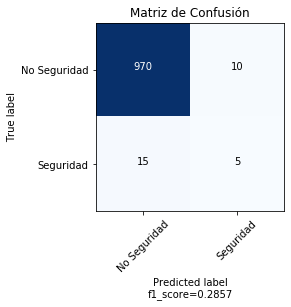

In [89]:
plot_confusion_matrix(confusion_matrix(data.seguridad,data.predict),
                      ['No Seguridad','Seguridad'],
                      f1_score(data.seguridad,data.predict),
                      path_save="test/confusion_matrix_filtro_0.png",
                      normalize=False
                     )

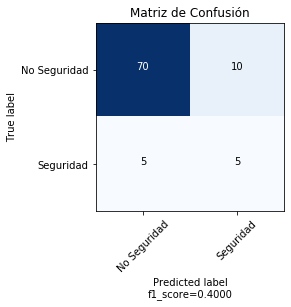

In [90]:
plot_confusion_matrix(confusion_matrix(data.seguridad[data.filtro],data.predict[data.filtro]),
                      ['No Seguridad','Seguridad'],
                      f1_score(data.seguridad[data.filtro],data.predict[data.filtro]),
                      path_save="test/confusion_matrix_filtro_0.png",
                      normalize=False
                     )

In [88]:
def plot_confusion_matrix(cm,
                          target_names,
                          f1=0,
                          title='Matriz de Confusión',
                          path_save="",
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = f1
    

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\nf1_score={:0.4f}'.format(accuracy))
    plt.savefig(path_save,bbox_inches='tight')
    plt.show()

from sklearn.metrics import confusion_matrix